# Trabajo Práctico 2: Reseñas de Películas - Naive Bayes

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

# Constants
SEED = 13

En esta notebook, detallamos el entrenamiento del modelo Naive Bayes que resultó obtener el mejor resultado en Kaggle.

## Carga de datos

Para el preprocesamiento de los datasets, se eliminó la repeticion de entidades y los tokens sin POS, se le agrego un Regex de limpieza manual, IOB encoding y manejo de las negaciones por enunciado (hasta siguiente signo de puntuacion).

Para ahorrar tiempo, importamos los CSVs ya preprocesados.

In [32]:
df_train = pd.read_csv("../datasets/train-complejo.csv", index_col=0)
df_test = pd.read_csv("../datasets/test-complejo.csv", index_col=0)

In [33]:
df_train.head()

,texto_preprocesado,num_neg,num_adj_neg,num_exclm,lang,sentimiento
ID,,,,,,
0,critico_NOUN mencionar_VERB oz_DET episodio_NO...,7,4,0,es,positivo
1,pequén_ADJ pequén_ADJ produccion_PROPN tecnica...,2,0,2,es,positivo
2,pense_VERB maravilloso_ADJ pasar_VERB tiempo_N...,2,0,1,es,positivo
3,basicamente_ADV familia_NOUN nino_NOUN pequeno...,0,0,4,es,negativo
4,amor_NOUN tiempo_NOUN pelicula_NOUN visualment...,1,2,0,es,positivo


Si bien este dataset contiene columnas adicionales que fueron construídas para ser utilizadas por otros modelos manteniendo un único dataset común, para el caso de Naive Bayes solo vamos a considerar la columna que contiene el texto preprocesado.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train.texto_preprocesado, df_train.sentimiento, test_size=0.2, random_state=SEED, stratify=df_train.sentimiento)

## Vectorización

Creamos el TFIDF vectorizer para convertir los datasets en matrices a usar en el modelo. Decidimos utilizar este método de vectorización en vez de Bag-of-Words debido a que terminó dando mejores resultados. Este método logra ignorar ciertas palabras en base a su frecuencia relativa en los documentos, por lo que nos ayuda a filtrar palabras muy comunes que pueden abundar tanto en críticas positivas como negativas.

Se probó con diferentes rangos de ngramas e incluso sin los mismos, pero finalmente el modelo tuvo mejor rendimiento cuando se utilizaron solamente ngramas de rango 1 a 2.

In [19]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    strip_accents="unicode",
    min_df=10
)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_train_vectorized

<40000x48088 sparse matrix of type '<class 'numpy.float64'>'
	with 3577453 stored elements in Compressed Sparse Row format>

## Entrenamiento

El modelo de Naive Bayes es muy sencillo, tanto que no tiene opciones de hiperparámetros para configurar, por lo que simplemente hacemos las predicciones con la versión por defecto.

In [20]:
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

MultinomialNB()

## Predicciones

Podemos analizar el rendimiento del modelo ante información que nunca ha visto utilizando el set de test que dividimos anteriormente.

              precision    recall  f1-score   support

    negativo       0.87      0.85      0.86      5000
    positivo       0.85      0.88      0.87      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



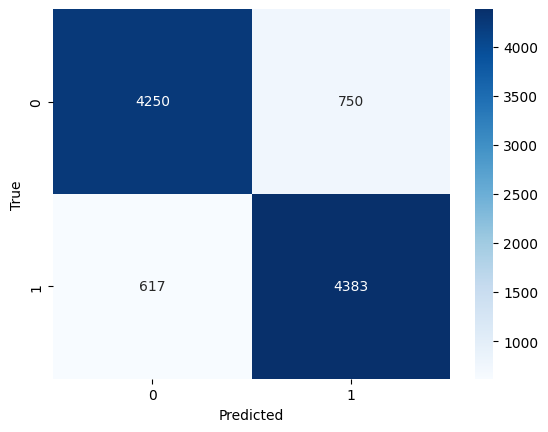

In [21]:
y_pred_test = clf.predict(X_test_vectorized)

sns.heatmap(metrics.confusion_matrix(y_test, y_pred_test), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred_test, zero_division=0))

Podemos observar que el modelo hace un buen trabajo prediciendo los valores reales de las categorías de las críticas de las películas, y también tiene una relativamente baja cantidad de falsos positivos y negativos.

# Submit Kaggle

Ya con la versión definitiva del modelo y la capa de vectorización, hacemos las predicciones para cargarlas a la competencia de Kaggle.

In [23]:
X_kaggle_vectorized = vectorizer.transform(df_test['texto_preprocesado'])
y_pred_kaggle = clf.predict(X_kaggle_vectorized)
df_test['sentimiento'] = y_pred_kaggle

In [24]:
df_test['sentimiento']

ID
60000    negativo
60001    negativo
60002    negativo
60003    positivo
60004    negativo
           ...   
68594    positivo
68595    negativo
68596    negativo
68597    negativo
68598    negativo
Name: sentimiento, Length: 8599, dtype: object

In [18]:
df_test['sentimiento'].to_csv('../predicciones/naive-bayes-final.csv')

# Guardado del Modelo

Exportamos el modelo para que pueda ser utilizado nuevamente sin necesidad de ser re-entrenado.

In [35]:
from joblib import dump

dump(clf, '../modelos/naive-bayes.joblib', compress=True)

['../modelos/naive-bayes.joblib']